# Topic Map

In [193]:
import os
import pandas as pd
import re
import nltk
import openai
import matplotlib
import matplotlib.pyplot as plt
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from bertopic import BERTopic
from nltk import sent_tokenize, word_tokenize
# nltk.download('punkt') < uncomment when you run it first time

pd.set_option('display.max_colwidth', None)
data_dir = '../data/'
processed_dir = data_dir + 'processed/'
os.makedirs(processed_dir + 'html', exist_ok = True)
os.makedirs(processed_dir + 'topic-map', exist_ok = True)
transcription_dir_location_en = processed_dir + 'transcription/en/'

## Parse Audio Transcriptions

To be able to topic model a text corpus some pre-processing is required. As the audio is spoken word some filler words need removed, inconsistent phrases like `Fratelli d'Italia` was converted to `Brothers of Italy` and Law `one hundred and ninety-four` to `194`. Posts with less than 27 words were ignored.

The topic model works best with individual sentences which were also keyed by the post date so that topics could be visualised over time. The complete parsed sentences were saved in a file to help with manual analysis.   

In [201]:
docs = []
filenames = []
timestamps = []
docs_word_count = []
# TODO sort by date

# the text contains spoken filler words that need removed 
stopwords = ['um', 'um,', 'mm,', 'eh', 'eh,', 'eh?', 'ah', 'ah,', 'mhm', 'mhm.', 'oh', 'oh,', 'oh.', 'huh?', 'hi']     
# RegExs for significant phrases 
FDI = re.compile(re.escape("fratelli d'italia"), re.IGNORECASE)
ninety_four = re.compile(re.escape("ninety four"), re.IGNORECASE)
one_hundred_and_ninety_four = re.compile(re.escape("one hundred and ninety-four"), re.IGNORECASE)

from datetime import datetime
 
DATE_TIME_FORMAT = '%Y-%m-%d %H:%M:%S'

def sort_dates(dates):
    # Define a key function that converts a date string to a datetime object
    def date_key(date_string):
        return datetime.strptime(date_string, DATE_TIME_FORMAT) # 2023-01-17 19:44:01 '%m/%d/%Y %I:%M %p'
     
    return sorted(dates, key=lambda x: date_key(x[0]))

def remove_stop_words(sentence):
    text_tokens = sentence.split(" ")
    tokens_filtered = [word for word in text_tokens if not word.lower() in stopwords]
    return (" ").join(tokens_filtered)

def parse_text(file_location): 
    transcriptions_df = pd.read_json(file_location, convert_dates=['createTime'])
    transcription_text = transcriptions_df['transcript'][0]
    transcription_create_time = transcriptions_df['createTime'][0].strftime(DATE_TIME_FORMAT)
    word_count = len(transcription_text.split()) 
    # only analyse files with sentences with more then 27 words
    if word_count < 27:
        print(f'Small number of words: {file_location} {transcription_text}')
        return
    docs_word_count.append(word_count)

    for sentence in sent_tokenize(transcription_text):
        timestamps.append(transcription_create_time)
        sentence = FDI.sub('Brothers of Italy', sentence)
        sentence = ninety_four.sub('ninety-four', sentence)
        sentence = one_hundred_and_ninety_four.sub('194', sentence)
        sentence = remove_stop_words(sentence)   
        filenames.append(file_location.removeprefix('../data/processed/transcription/en/TranscribeTikTokAudio').removesuffix('.json'))              
        docs.append(sentence)
    
for file_name in os.listdir(transcription_dir_location_en):
    parse_text(transcription_dir_location_en + file_name)

print(len(timestamps))
print(len(docs))
print(len(filenames))

docs_dict = zip(timestamps, filenames, docs)
  
sorted_dates = sort_dates(list(docs_dict))

with open(processed_dir + '/topic-map/all-docs-text.txt', 'w') as file: 
 	file.writelines('{0} \n'.format(value) for value in sorted_dates) 

word_count_df = pd.DataFrame(zip(timestamps, docs_word_count), columns=['timestamp','word_count'])  
word_count_df.to_json(processed_dir + '/wordcount.json')

start_date = '2022-07-21'
end_date = '2022-09-26'

docs_df = pd.DataFrame(zip(timestamps, docs), columns=['timestamp','docs'])  

mask = (docs_df['timestamp'] > start_date) & (docs_df['timestamp'] <= end_date)
election_dates_df = docs_df.loc[mask]


Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7147206448232074502.json gentlemen, It was the day of defeat. But this is not the day to get things done. Well, that wasn't really the case. That's fine. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7147263913200045317.json September twenty-fifth I've said it all. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7135145359629634822.json 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7144425341279341830.json I am
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7070073900100521222.json who goes M design, yo. 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7144420910336953606.json 
Small number of words: ../data/processed/transcription/en/TranscribeTikTokAudio7143163842665663749.json 
Small number of words: ../data/processed/transcription/en/Transcribe

## Topic Model

The steps that follow configure BERTopic so that is can run and create a topic model. For more information see the BERTopic documentation and the best practices.

### Pre-calculate Embeddings

In [202]:
from bertopic.backend import OpenAIBackend

# all-mpnet-base-v2 - is the best embedding model but slow
embedding_model = SentenceTransformer('all-mpnet-base-v2')
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/74 [00:00<?, ?it/s]

### Stochastic Behaviour

In [203]:
from bertopic import BERTopic
from sklearn.decomposition import PCA

# umap_model = PCA()
umap_model = UMAP(n_neighbors=15, 
                  n_components=5, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=42)

### Limit Number of Topics

In [204]:
hdbscan_model = HDBSCAN(
    min_cluster_size=10, 
    metric='euclidean', 
    cluster_selection_method='eom', 
    min_samples=8, # added to reduce outliers
    prediction_data=True)

### Improving Default Representation

This isn't used as it seemed to remove words that were important.  

In [205]:
vectorizer_model = CountVectorizer(stop_words="english")

### Representation Models

In [275]:
# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# Chat-GPT-3.5
openai.api_key=os.environ['openai_api_key'] 
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
openai_model = OpenAI(model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt)

from bertopic.representation import ZeroShotClassification

candidate_topics = [
    'migrants', 
    'abortion', 
    'fake news', 
    'Brothers of Italy', 
    'we are ready',
    'rape',
    'Nazis',
    'minimum wage',
    'ecological',
    'green pass',
    'russia'
    'crime', # this is used to separate out crime from migration
    'authoritarian',
    'women',
    'inflation', 
    'citizenship', 
    'freedom',
    'prices',
    'pensions',
    'tax',
    'family',
    ]

zero_shot_model = ZeroShotClassification(candidate_topics, model="facebook/bart-large-mnli")
representation_model = zero_shot_model
# representation_model = {
#     "Main": zero_shot_model,
#     # 'OpenAI': openai_model,  # Uncomment if you will use OpenAI
#     # 'MMR': mmr_model,
#     # 'KeyBERT': keybert_model,
#     # 'POS': pos_model,
# }

### Seed Topics

These are used to encourage the topic model to map domain relevant topics.

In [250]:
seed_topic_list = [  
    ['Brothers of Italy', 'brothers of italy', 'Italy', 'Italian'],
    ['we are ready'], # The FDI's Campaign slogan     
    ['immigration', 'migration', 'migrants', 'refugee', 'traffickers'],
    ['abortion', 'abort', '194', 'law 194'],
    ['election', 'government', 'vote'],
    ['inflation', 'bills'],
    ['freedom'],
    ['rape', 'raped'],
    ['women'],
    ['climate' , 'environmental', 'ecological',  'sustainability'],
    ['fake', 'fake news', 'lies', 'journalism'],
    ['tax', 'income'],
    ['crime'],
    ['minimum wage'],
    ['Nazis', 'nazis'],
    ['pensions'],
    ['family', 'families'],
    ['pets', 'animals'], # added as pets get merge into the migrants topic    
    ['russia']       
    ]

Run the Topic Model

Now that BERTopic is configured it can be run. The output is a list of topics and associated topic counts. The first row is a group of outliers that are not used in the topic model. 

In [328]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True, bm25_weighting=True)

topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  # vectorizer_model=                       # Step 4 - Tokenize topics. Don't do this! It removed the entire abortion topic.
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  seed_topic_list= seed_topic_list,
  min_topic_size=10, # 10 is the default
  nr_topics=29, # 32
  verbose=True,
  n_gram_range=(1,3), # allows Brothers of Italy
  calculate_probabilities=True,
)

topics, probs = topic_model.fit_transform(docs)
# topic_labels = topic_model.generate_topic_labels(nr_words=3, topic_prefix=False, word_length=20, separator=', ')
# topic_model.set_topic_labels(topic_labels)
# 744 outliers
topic_model.get_topic_info()

Batches:   0%|          | 0/74 [00:00<?, ?it/s]

2023-11-22 11:34:48,535 - BERTopic - Transformed documents to Embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-22 11:34:59,922 - BERTopic - Reduced dimensionality
2023-11-22 11:35:00,364 - BERTopic - Clustered reduced embeddings
2023-11-22 11:42:05,031 - BERTopic - Reduced number of topics from 63 to 29


,Topic,Count,Name,Representation,Representative_Docs
0,-1,707,-1_government_have_are_because,"[government, have, are, because, this, we, it, on, not, is]","[We have started important work to make the places that our students frequent more modern and then again on young people, from the culture card to the Merit Card, in favor respectively of the kids with the lowest ISEE and the deserving ones up to the increase of the sports in the suburbs, passing through the five hundred million allocated to scholarships for university housing allocations, we have reiterated the principle that equality and merit are one prerequisite for the other from the provision to simplify the first thirty administrative procedures up to the highly anticipated reform of the procurement code we have started a profound revision to make the State more streamlined, more understandable, more efficient., Let's say that we made a couple of jokes and I told her on the question of Emilia Romagna that I had responded with a long letter to the continuous complaints of President Bonaccini which in my opinion are poorly founded and that on the question of De Angelis I don't think I have to deal with the communication manager of the Region because I think it is the responsibility of the President of the Region, he considers the sixty days a commitment on the part of the government to close the issue of the instruments that I have formalized with the President of the CNEL and they guarantee me that they are able to do this work in sixty days., Jesus, Giorgia Meloni, J. Carron, Sanka Gesù, the president of Brothers of Italy left her parts preserved Italian Brothers of Italy and Draghi Brothers of Italy her parts and that the time and the deterioration, the the the the, the the the the the the surviving tragic, the Soviet Union for the misma bla of freedom, positioning of the current world and in what I don't know, we synergistically put in casts anti-democratic drift with palabras signatures that we don't always encounter if the group is Italian, European and even in the next one is the change represented for brothers of Italy, however, of Western freedom to maintain the farm during agnos and of garrisons the European conservative party which with the stories and American Israeli position in the Western field is crystal clear with the pink aggression against Ukraine, the contribute to bring if the Italian position in Europe and internationally our idea of ​​Europe and Slade is a political entity capable of representing an additional real value with less bureaucracy, the greats assumed that it shoots the future of Italy CSL dynamic and presides over the world that has contributed to large Europe.]"
1,0,290,0_italy_brothers of italy_brothers_of italy,"[italy, brothers of italy, brothers, of italy, brothers of, italian, in italy, italians, meloni, government]","[And this is the reason why today I sent a letter to the European Council and the European Commission to ask that what we discussed at the last Ukrainian European Council meeting be immediately made concrete, we saw her moved in front of the children's soft toys killed on the bus and you confirmed to Zaleski the full support of the Italian government, despite an important part of public opinion being against the sending of weapons, I was moved by some soft toys in the rain in memory of some children because my daughter has some a similar one and however I also want to tell you that I thought that Italians should be very proud of them instead., This instability has produced our economic weakness, it has produced the credibility problems that we may have also had at an international level, when our interlocutors often remain the same interlocutor for at least a few years and every time they sit with an Italian exponent they ask themselves the next once again, who knows if this person will be my interlocutor again on the part of Italy and they have produced the disaffection on the part of the citizens that we see and 

### Reduce Outliers

Merge redundant topics with outliers - except it worked at the start and no longer works now. 

In [329]:
new_topics = topic_model.reduce_outliers(docs, topics, probabilities=probs, strategy="probabilities")

topic_model.update_topics(docs, topics=new_topics, ctfidf_model=ctfidf_model,                
    representation_model=representation_model,
    n_gram_range=(1,3), # allows 'Brothers of Italy' as a 3 word n-gram
    )
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,424,0_italy_brothers of italy_italian_of italy,"[italy, brothers of italy, italian, of italy, brothers, brothers of, government, in italy, italians, in]","[And this is the reason why today I sent a letter to the European Council and the European Commission to ask that what we discussed at the last Ukrainian European Council meeting be immediately made concrete, we saw her moved in front of the children's soft toys killed on the bus and you confirmed to Zaleski the full support of the Italian government, despite an important part of public opinion being against the sending of weapons, I was moved by some soft toys in the rain in memory of some children because my daughter has some a similar one and however I also want to tell you that I thought that Italians should be very proud of them instead., This instability has produced our economic weakness, it has produced the credibility problems that we may have also had at an international level, when our interlocutors often remain the same interlocutor for at least a few years and every time they sit with an Italian exponent they ask themselves the next once again, who knows if this person will be my interlocutor again on the part of Italy and they have produced the disaffection on the part of the citizens that we see and to deliver to Italy a reform which, let's be clear, we are doing for ourselves, because it is a reform which we hand over to the next government and therefore we hand over to all the political forces., The theme here is if you want to do something, whatever you want to do, you do it respecting the rules and laws of the Italian state because there isn't some idiot who respects them and someone else who doesn't have to respect them, this Italy here, as I see it, it's over, that is, someone who knows how to do it better make their proposals but don't use hypotheses that have nothing to do with the rationale of the law and with our intention to prevent this State from saying that we are no longer the banana republic, because I don't follow them on this, I move forward and I believe that this is what Italians expect from me and from the government currently in office]"
1,1,473,1_government_we_immigration_this,"[government, we, immigration, this, are, from, who, of the, with, have]","[we dealt with immigration in the same Council of Ministers with a decree which mainly concerns the issue of NGOs which has as its objective the respect of international law because trivially the international law on rescue at sea does not provide that there is someone who can make the ferry in the Mediterranean or any other sea and go back and forth with smugglers to transfer people from one country to another., The route is not covered by non-governmental organizations and therefore the government's measures on non-governmental organizations have nothing to do with this, with this matter, I point out to you and I believe you must bear witness to the fact that despite us continuing to work to stop the flows of illegal immigration, also to prevent people from dying, we have since the beginning of this government continued to save all the people we could save when we were aware that they were at risk., match of E Times for showing can be free people and a supra nation security and international British moldova with food and time the witch show the on I club Europe is more and be and us from from witch depend from from Hades cast principal in Detroit from helping yn to shapes from your The Walk yn Moldova Georgian Western to the European Union A witch mins wedding European Union Coming Back to get York SE Europe S John Paul II The Pop Set West the Est and A in the the solution Security Account Witch The Energetic One The capacity from and remember Global Relations Africa the Migration HTS Nations to too]"
2,2,371,2_you_me_here_this,"[you, me, here, this, it, are, we are, what, say, we]","[So I have decided that in the meantime I will cle

In [209]:
# outliers 
# realize       = [-1, 6]    # realize, what you ar
# heard         = [-1, 17]    # ve heard, what
# what          = [-1, 21]   # what you are
# we            = [-1, 26]    # we are
# what            = [-1, 3]     # what are, serious,
# yes             = [-1, 11]    # yes, yes yes
# thanks          = [-1, 14]    # you thank, you
# good_morning    = [-1, 23]    # good morning
# why             = [-1, 27]    # why, why why

# topics_to_merge = [-1, 11, 14, 23, 27]
# print(topics_to_merge)
# topic_model.merge_topics(docs, topics_to_merge=topics_to_merge)     
# topic_model.get_topic_info().head()

Rename Topics

In [330]:
def formatted_label(topic_model, index, labels):
    names = [item.replace(',', '').strip().title() for item in labels if item.strip()]
    # Brothers Of Italy
    # FDI = re.compile(re.escape("fratelli d'italia"), re.IGNORECASE)
    top_three = ', '.join(names[:3]).replace('Green Pass', 'COVID Mandates')
    offset = index + 1 # this hack is for the index by topic id
    label = {offset : top_three}
    
    if offset < topic_model.get_topic_info().shape[0]:
        print(label)
        topic_model.set_topic_labels(label)
    
# name_column = topic_model.get_topic_info()['ZeroShot']
print(topic_model.get_topic_info().columns)
print(topic_model.get_topic_info().shape[0])
name_column = topic_model.get_topic_info()['Representation']    
for label, index in enumerate(name_column):
    formatted_label(topic_model, label, index) 

topic_model.get_topic_info().head(50)

Index(['Topic', 'Count', 'Name', 'Representation', 'Representative_Docs'], dtype='object')
28
{1: 'Italy, Brothers Of Italy, Italian'}
{2: 'Government, We, Immigration'}
{3: 'You, Me, Here'}
{4: 'Income, Tax, Euros'}
{5: 'Minimum Wage, Work, Wage'}
{6: 'Thank, Thank You, Thank The'}
{7: 'Yes, Okay, Enough'}
{8: 'Freedom, Free, On Social'}
{9: 'Credits, Credit, Inflation'}
{10: 'Vote, Of The Republic, The Republic'}
{11: 'We Are Ready'}
{12: 'Ecological, Supply, Sustainability'}
{13: 'Emergency, Estimate, The Damage'}
{14: 'Family, Christmas, Families'}
{15: 'Russia, Putin, Values'}
{16: 'Women'}
{17: 'Abortion, 194, The 194'}
{18: 'Thank You Thank, You Thank You, You Thank'}
{19: 'Tax'}
{20: 'Prices'}
{21: 'Fake News'}
{22: 'Not Know, Do Not Know, The Rules'}
{23: 'Rape, Of Rape, Surreal'}
{24: 'Sport, How Many, Sports'}
{25: 'Why, Why Why, Why Not'}
{26: 'Ministers, Group Leaders, Group'}
{27: 'Good Morning, Morning, Good'}


,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,0,424,0_italy_brothers of italy_italian_of italy,"Italy, Brothers Of Italy, Italian","[italy, brothers of italy, italian, of italy, brothers, brothers of, government, in italy, italians, in]","[And this is the reason why today I sent a letter to the European Council and the European Commission to ask that what we discussed at the last Ukrainian European Council meeting be immediately made concrete, we saw her moved in front of the children's soft toys killed on the bus and you confirmed to Zaleski the full support of the Italian government, despite an important part of public opinion being against the sending of weapons, I was moved by some soft toys in the rain in memory of some children because my daughter has some a similar one and however I also want to tell you that I thought that Italians should be very proud of them instead., This instability has produced our economic weakness, it has produced the credibility problems that we may have also had at an international level, when our interlocutors often remain the same interlocutor for at least a few years and every time they sit with an Italian exponent they ask themselves the next once again, who knows if this person will be my interlocutor again on the part of Italy and they have produced the disaffection on the part of the citizens that we see and to deliver to Italy a reform which, let's be clear, we are doing for ourselves, because it is a reform which we hand over to the next government and therefore we hand over to all the political forces., The theme here is if you want to do something, whatever you want to do, you do it respecting the rules and laws of the Italian state because there isn't some idiot who respects them and someone else who doesn't have to respect them, this Italy here, as I see it, it's over, that is, someone who knows how to do it better make their proposals but don't use hypotheses that have nothing to do with the rationale of the law and with our intention to prevent this State from saying that we are no longer the banana republic, because I don't follow them on this, I move forward and I believe that this is what Italians expect from me and from the government currently in office]"
1,1,473,1_government_we_immigration_this,"Government, We, Immigration","[government, we, immigration, this, are, from, who, of the, with, have]","[we dealt with immigration in the same Council of Ministers with a decree which mainly concerns the issue of NGOs which has as its objective the respect of international law because trivially the international law on rescue at sea does not provide that there is someone who can make the ferry in the Mediterranean or any other sea and go back and forth with smugglers to transfer people from one country to another., The route is not covered by non-governmental organizations and therefore the government's measures on non-governmental organizations have nothing to do with this, with this matter, I point out to you and I believe you must bear witness to the fact that despite us continuing to work to stop the flows of illegal immigration, also to prevent people from dying, we have since the beginning of this government continued to save all the people we could save when we were aware that they were at risk., match of E Times for showing can be free people and a supra nation security and international British moldova with food and time the witch show the on I club Europe is more and be and us from from witch depend from from Hades cast principal in Detroit from helping yn to shapes from your The Walk yn Moldova Georgian Western to the European Union A witch mins wedding European Union Coming Back to get York SE Europe S John Paul II The Pop Set West the Est and A in the the solution Security Account Witch The Energetic One The capacity from and remember Global Relations Africa the Migration HTS Nations to too]"
2,2,371,2_you_me_here_this,"You, Me, Here","[you, me, her

In [287]:
heatmap_fig = topic_model.visualize_heatmap() # n_clusters=20, topics=[4, 18, 26, 21,44]custom_labels=True
heatmap_fig.write_html(processed_dir + 'html/similarity-matrix.html')
heatmap_fig

### Visualise Topic Frequency Count 

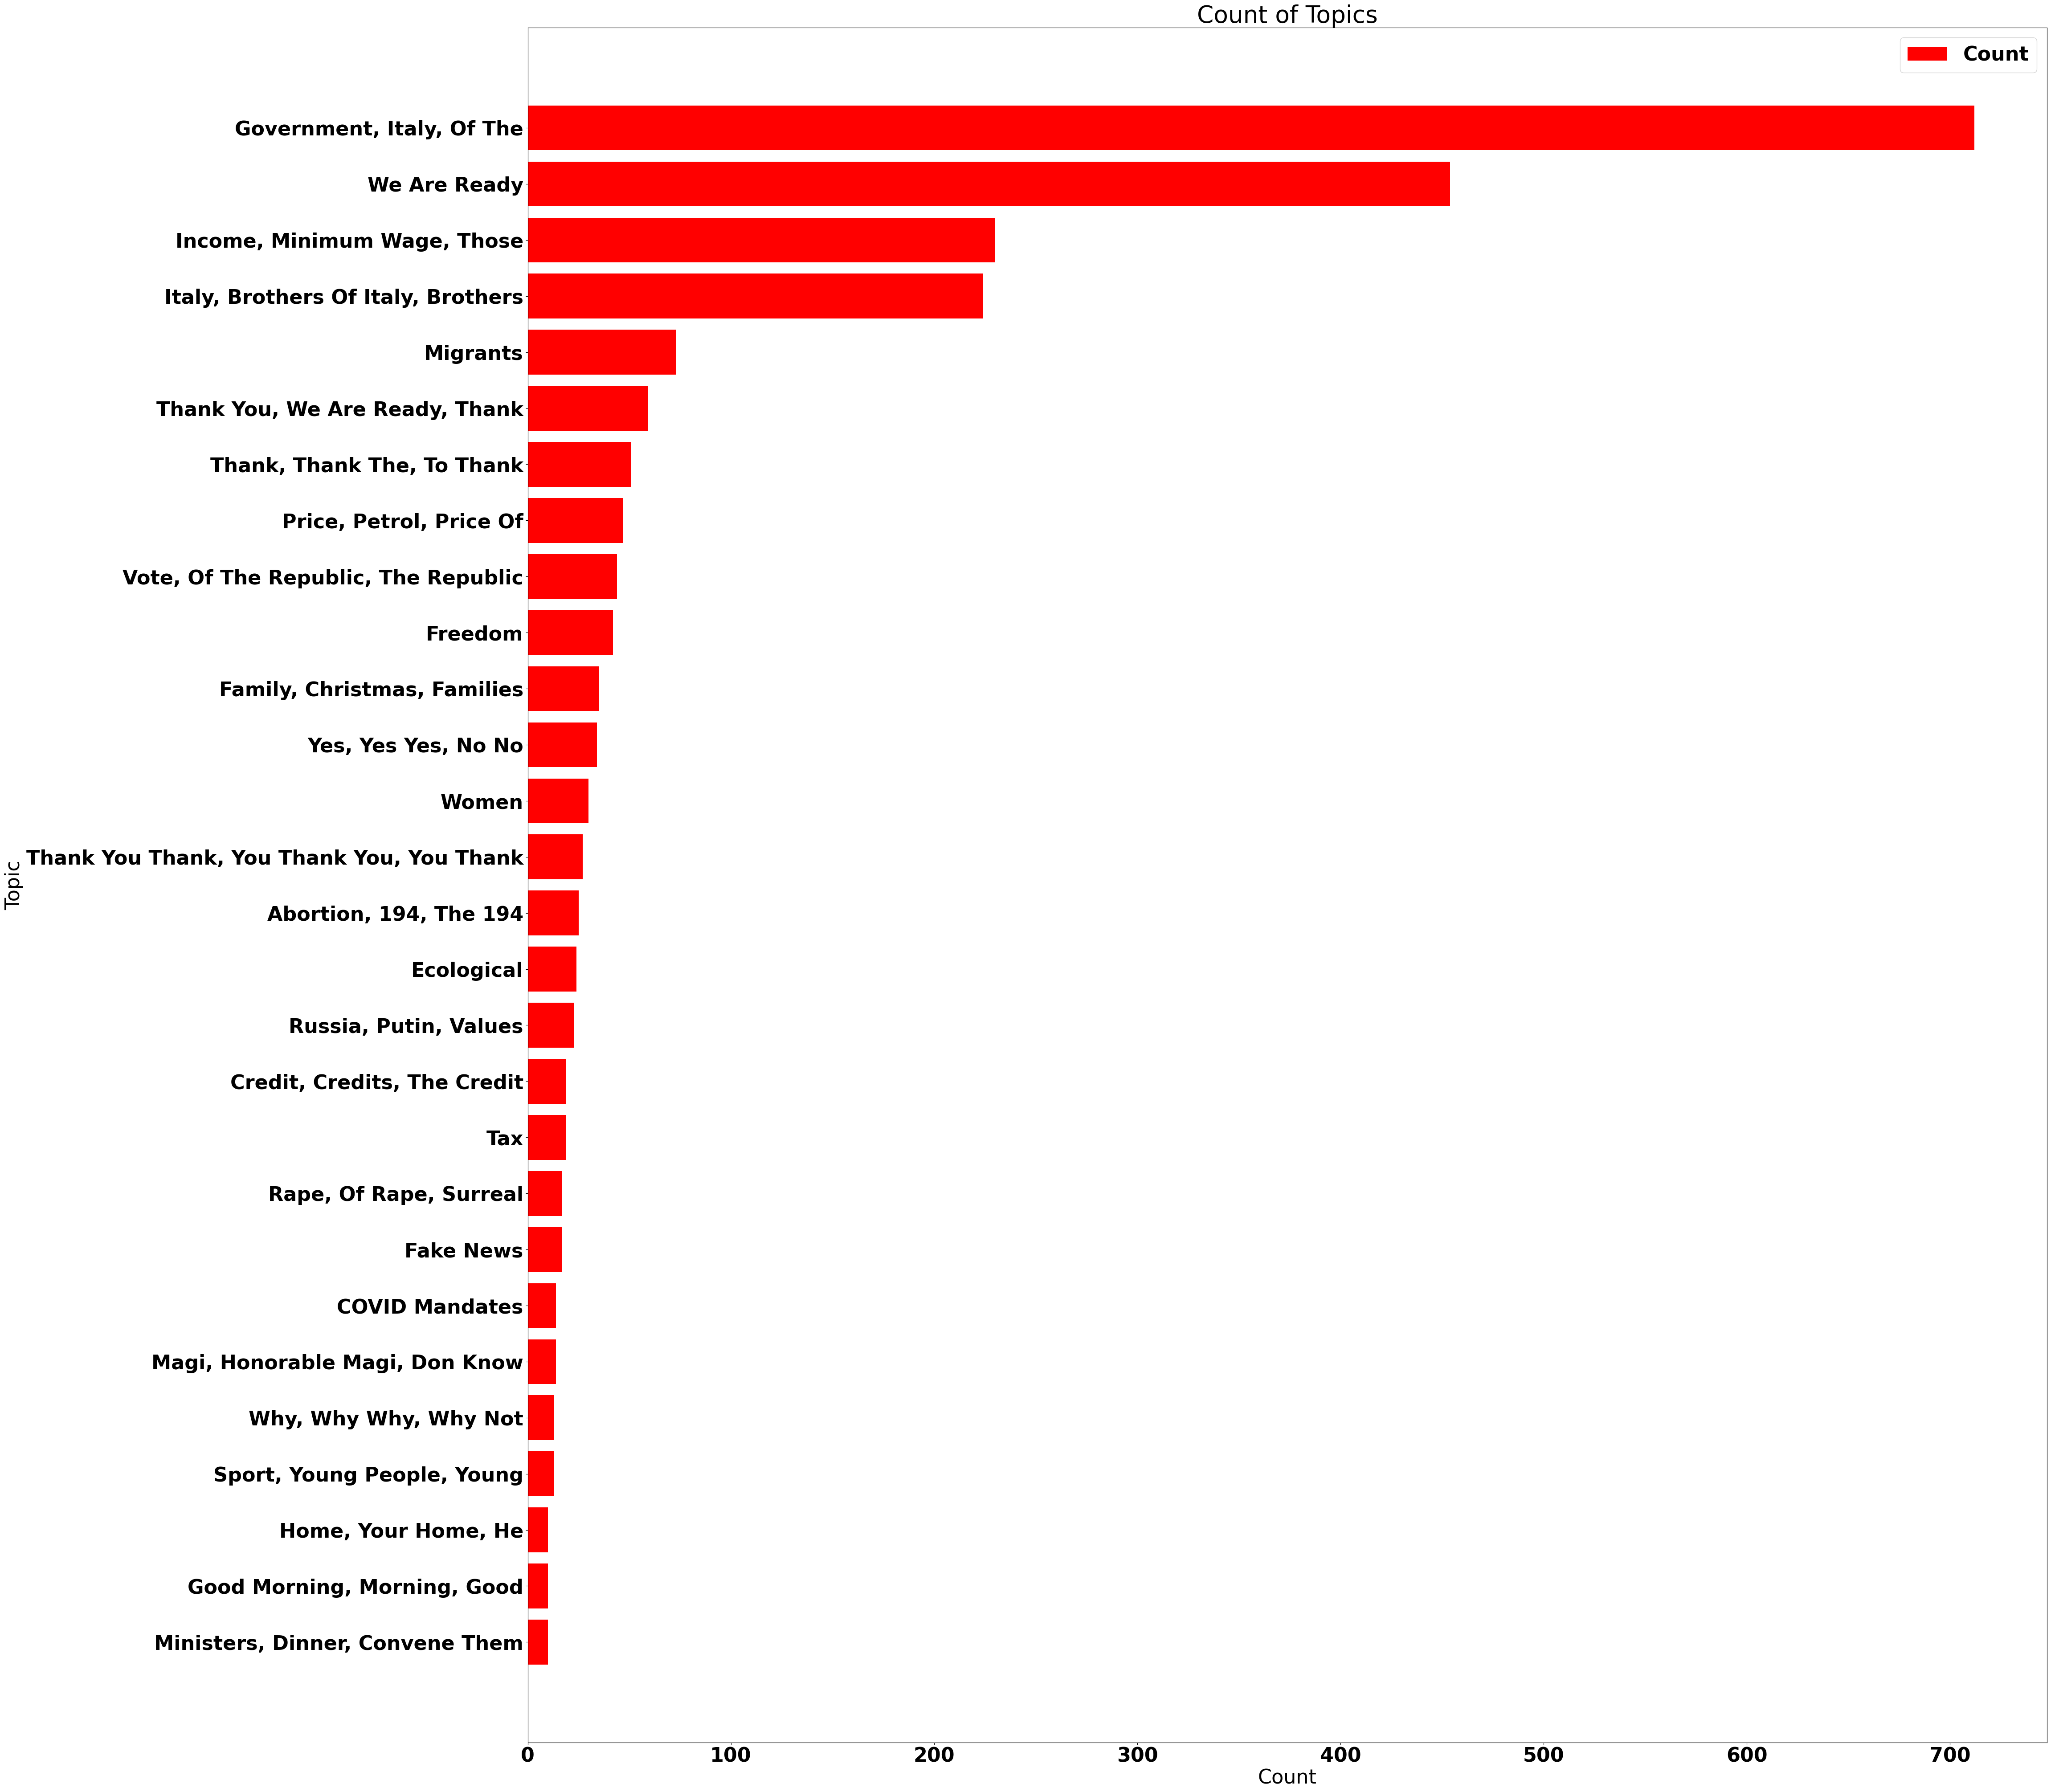

In [288]:
plt_df = topic_model.get_topic_info()
# plt_df = plt_df.drop([0])
plt_df = plt_df.sort_values(by='Count', ascending=True)

f = plt.figure()
f.set_figwidth(44)
f.set_figheight(50)
plt.barh(plt_df['CustomName'], plt_df['Count'], label = "Count", color='red')
font = {'weight' : 'bold',
        'size'   : 32}
plt.rc('font', **font)

plt.title('Count of Topics')
plt.xlabel('Count')
plt.ylabel('Topic')

plt.legend()
plt.savefig(processed_dir + 'images/topic-document-counts.png')
plt.show()

Show the documents in a particular topic

In [289]:
fig = topic_model.visualize_barchart(width=280, height=330, top_n_topics=60, n_words=13, custom_labels=True)
fig.write_html(processed_dir + 'html/topic-word-scores.html')
fig

## Documents in Specific Topic

In [291]:
representative_docs = topic_model.get_representative_docs(3)
representative_docs

freedom = 10
fake_news = 20

df = pd.DataFrame({'Topic': topics, 'document': docs})
df[df['Topic'] == freedom].head(50)
df[df['Topic'] == fake_news].head(50)

,Topic,document
643,20,This is also a hoax.
683,20,"Easy it doesn't take much you have to study, know how to read and then but why?"
769,20,"If I've always said the same thing, there's probably no reason to keep making up fake news."
770,20,"I don't need to invent fake news about my opponents, I just need to say who I really am because they need to invent fake news about me."
1015,20,"don't be scared, don't be scared, it's not true."
1016,20,"Everything they told you about the elections, that they are scary, that they are a problem that stops everything, nothing stops,"
1100,20,The din of war has collapsed the progressive narrative.
1143,20,I usually tell the truth.
1297,20,"For days I have been hearing total lies, fake candidates that are sent by Italian brothers around the internet, fake parts of the program, proposals that have never existed, that when there is a need to invent lies about someone it means that that person someone is right because otherwise you don't need to lie."
1647,20,"of altitude Oxygen is rarefied, it can make you dizzy, it can make you lose your way."


## Topic Frequency

In [292]:
df_topic_freq = topic_model.get_topic_freq()
topics_count = len(df_topic_freq) - 1
df_topic_freq

,Topic,Count
3,-1,712
0,0,454
1,1,230
4,2,224
14,3,73
8,4,68
5,5,59
15,6,51
2,7,47
6,8,44


## Visualise Topics

In [293]:
fig = topic_model.visualize_topics(custom_labels=True)
fig.write_html(processed_dir + 'html/inter-topic-distance-map.html')
fig

## Topics over time 

Make sure to use a limited number of unique timestamps (<100) as the c-TF-IDF representation will be calculated at each single unique timestamp. Having a large number of unique timestamps can take some time to be calculated. Moreover, there aren't many use-cased where you would like to see the difference in topic representations over more than 100 different timestamps.

In [266]:
topics_over_time = topic_model.topics_over_time(docs, timestamps)
intertopic_fig = topic_model.visualize_topics_over_time(topics_over_time=topics_over_time, custom_labels=True)
intertopic_fig.write_html(processed_dir + 'html/topics-over-time.html')
intertopic_fig

168it [14:55:36, 319.86s/it] 


In [296]:
documents_and_topics_fig = topic_model.visualize_documents(docs, topics=topics, custom_labels=True)
documents_and_topics_fig.write_html(processed_dir + 'html/documents-and-topics.html')
documents_and_topics_fig

In [295]:
doc_id = 123
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True)
topic_model.visualize_approximate_distribution(docs[doc_id], topic_token_distr[doc_id])

100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


,whatever,have,done,in,my,life,most,have,bet,on,my,failure,it,has,something,to,do,with,the,fact,that,was,woman,probably,yes,and,it,is,something,that,realized,very,late,in,my,existence
12_women___,0.000,0.000,0.000,0.000,0.100,0.204,0.306,0.410,0.418,0.417,0.415,0.311,0.203,0.100,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.105,0.208,0.208,0.208,0.103,0.000,0.000,0.000,0.104,0.208,0.310,0.417,0.312,0.208,0.106
